In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import numpy as np
from time import time
import pandas as pd
from scipy.stats import norm
import seaborn as sns
sns.set_context("notebook", font_scale=0.9, rc={"lines.linewidth": 2.5})
sns.set_style('dark')


In [20]:
def blackScholesPriceTrue(S0, r, K, T, vol):
    F = S0*np.exp(-r*T)
    Strike = S0*K
    sqt = vol * np.sqrt(T)
    d1 = (np.log(F / Strike) + 0.5 * vol* vol * T)/sqt
    d2 = d1 - sqt
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    return n1 - Strike/F * n2

def createDataset(size):
    S0 = np.random.uniform(50,150, size)
    r = np.random.uniform(0.001,0.03, size)
    K = np.random.uniform(0.5,1.5, size)
    T = np.random.uniform(0.5,1,size)
    vol = np.random.uniform(0.01, 0.5, size)
    options = blackScholesPriceTrue(S0, r, K, T, vol)
    columns = "spots,rates,strikes,tenors,optionPrices,vols".split(',')
    data = np.array([S0, r, K, T, options, vol])
    data = pd.DataFrame(data=data.T, columns=columns)
    data = data[data["optionPrices"]>=0.01]
    return data


In [21]:
#data = pd.read_csv("bsFrame.csv")
sample_size = 100000
data = createDataset(sample_size)
data.tail()


,spots,rates,strikes,tenors,optionPrices,vols
99994,65.730471,0.003591,1.362682,0.593208,0.025150,0.380819
99996,128.165676,0.024559,0.924959,0.795303,0.173652,0.417558
99997,120.666259,0.017222,0.856256,0.880108,0.130668,0.038043
99998,94.301873,0.020546,0.883226,0.962897,0.206629,0.411538
99999,94.261576,0.004121,0.567727,0.835690,0.445583,0.478904


In [22]:
train_data = data.sample(frac=0.8,random_state=0)
test_data = data.drop(train_data.index)
train_stats = train_data.describe()
train_stats.pop("vols")
train_stats = train_stats.transpose()

train_labels = train_data.pop('vols')
test_labels = test_data.pop('vols')

def normalize(x):
    return (x - train_stats['mean']) / train_stats['std']

In [23]:
normed_train_data = normalize(train_data)
normed_test_data = normalize(test_data)


In [24]:
#sns.pairplot(train_data.loc[:500, :],diag_kind="kde")

In [25]:
model=keras.Sequential( [layers.Dense(64, activation='relu', input_shape=[len(train_data.keys())]),
layers.Dense(128, activation="tanh"),
layers.Dense(128, activation="tanh"),
layers.Dense(128, activation="tanh"),
layers.Dense(128, activation="tanh"),
layers.Dense(1, activation="elu"),
layers.Dense(1)])
optimizer = tf.keras.optimizers.RMSprop(0.01)
model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [26]:

modelFile = 'bsCalibratorModel.hdf5'
epochs = 1000

checkpoint = callbacks.ModelCheckpoint(modelFile, monitor='val_loss')
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
    
history = model.fit(normed_train_data, train_labels,  batch_size=1024,
    epochs=epochs, validation_split = 0.2, verbose=0, shuffle=True,
    callbacks=[PrintDot(), checkpoint, reduce_lr, early_stop])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

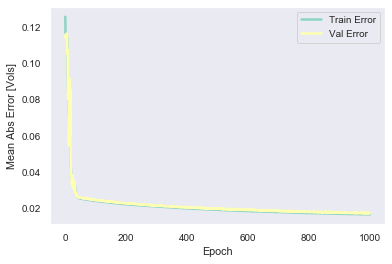

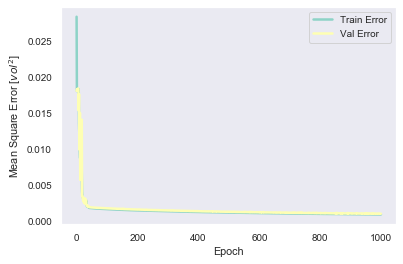

In [27]:

#%%

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Vols]')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label = 'Val Error')
    plt.legend()
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$vol^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label = 'Val Error')
    plt.legend()

  
  
plot_history(history)


(-0.024337368726539795,
 0.5475762818498916,
 -0.02681999589629146,
 0.5450936546801399)

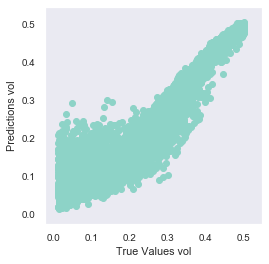

In [28]:

#%%

test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values vol')
plt.ylabel('Predictions vol')
plt.axis('equal')
plt.axis('square')
# plt.xlim([0.0, plt.xlim()[1]])
# plt.ylim([0.0, plt.ylim()[1]])


Text(0.5, 0, 'Prediction Error [vols]')

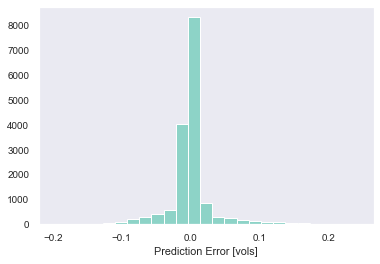

In [29]:

#%%
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [vols]")
